
# Package Importation



In [1]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

# Attach to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
InputPath="/content/drive/MyDrive/ml_projects/low_light_image_enhancer/LOLdataset/train/high"

# Noise Addition

In [11]:
def addNoise(image):
    #salt and pepper noise
    noiseAddedImage = np.copy(image)
    coords = [np.random.randint(0, i, int(np.ceil(image.size * 0.5)))
          for i in image.shape]
    noiseAddedImage[coords] = 1
    coords = [np.random.randint(0, i , int(np.ceil(image.size * (1.0 - 0.5))))
          for i in image.shape]
    noiseAddedImage[coords] = 1
    return noiseAddedImage

# Original Image and Noise Image

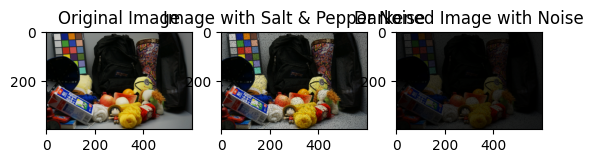

In [47]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def addNoise(image):
    # salt and pepper noise
    noiseAddedImage = np.copy(image)

    # Adding salt (white) noise
    num_salt = np.ceil(image.size * 0.01)  # Percentage of image to be "salt"
    coords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[:2]]
    noiseAddedImage[coords[0], coords[1], :] = 1  # Apply to all channels

    # Adding pepper (black) noise
    num_pepper = np.ceil(image.size * 0.01)  # Percentage of image to be "pepper"
    coords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[:2]]
    noiseAddedImage[coords[0], coords[1], :] = 0  # Apply to all channels

    return noiseAddedImage

# Load image
img = cv.imread(InputPath+"/517.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Plot original image
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original Image')

# Plot image with noise
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.title('Image with Salt & Pepper Noise')

# Convert to HSV and apply noise again
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)  # Convert to HSV
hsv[...,2] = hsv[...,2] * 0.2  # Darken the value channel
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)  # Convert back to RGB

Noise2 = addNoise(img1)
plt.imshow(Noise2)
plt.title('Darkened Image with Noise')

plt.show()


# Data Preprocessing

In [15]:
from tqdm import tqdm
HighPath = "/content/drive/MyDrive/ml_projects/low_light_image_enhancer/LOLdataset/train/high"

def PreProcessData(ImagePath):
    X_ = []
    y_ = []
    count = 0

    # Iterate over all images in the provided directory
    for imageName in tqdm(os.listdir(HighPath)):
        count += 1
        imagePath = os.path.join(HighPath, imageName)

        # Load the image
        low_img = cv.imread(imagePath)
        if low_img is None:
            print(f"Warning: Skipping {imageName}, could not load the image.")
            continue

        # Convert BGR to RGB
        low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)

        # Resize the image to 500x500
        low_img = cv.resize(low_img, (500, 500))

        # Convert to HSV and darken the image by reducing the value channel
        hsv = cv.cvtColor(low_img, cv.COLOR_RGB2HSV)
        hsv[..., 2] = hsv[..., 2] * 0.2
        img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)

        # Apply noise to the darkened image
        Noisey_img = addNoise(img_1)

        # Append the processed noisy image and original low image to the lists
        X_.append(Noisey_img)
        y_.append(low_img)

    # Convert the lists to NumPy arrays
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_, y_

In [18]:
X_,y_ = PreProcessData(InputPath)

100%|██████████| 486/486 [00:10<00:00, 44.32it/s]


# Model Creation

In [19]:
K.clear_session()
def InstantiateModel(in_):

    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)

    return model_5


In [20]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 500, 500, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 500, 500, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 500, 500, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 500, 500, 32)   │          4,640 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 500, 500, 64)   │          8,256 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 500, 500, 64)   │          8,256 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 500, 500, 64)   │         16,448 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 500, 500, 64)   │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 500, 500, 64)   │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 500, 500, 32)   │         18,464 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 500, 500, 32)   │         18,464 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 500, 500, 16)   │          2,064 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 500, 500, 16)   │          4,112 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 500, 500, 16)   │          2,064 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 500, 500, 16)   │              0 │ conv2d_10[0][0],       │
│                           │                        │                │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 500, 500, 16)   │          9,232 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 500, 500, 16)   │          2,320 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)          

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from keras.utils import plot_model
plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

# Training

In [42]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_Enhancer.fit(GenerateInputs(X_,y_),epochs=53,verbose=1,steps_per_epoch=8,shuffle=True) #epochs * steps_per_epoch <= training dataset images...

Epoch 1/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 8560.6973
Epoch 2/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5243.9160
Epoch 3/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4245.4072
Epoch 4/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6256.5483
Epoch 5/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5702.9233
Epoch 6/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6137.4321
Epoch 7/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5025.3374
Epoch 8/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4492.3896
Epoch 9/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5360.3765
Epoch 10/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 4989.9883
Epoch 11/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 5732.9727
Epoch 12/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5168.0928
Epoch 13/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 4746.0547
Epoch 14/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5661.5039
Epoch 15/53
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss

In [48]:
TestPath="/content/drive/MyDrive/ml_projects/low_light_image_enhancer/LOLdataset/val/high"

In [44]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img,(500,500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV) #convert it to hsv
    hsv[...,2] = hsv[...,2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1,500,500,3)
    return Noise

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


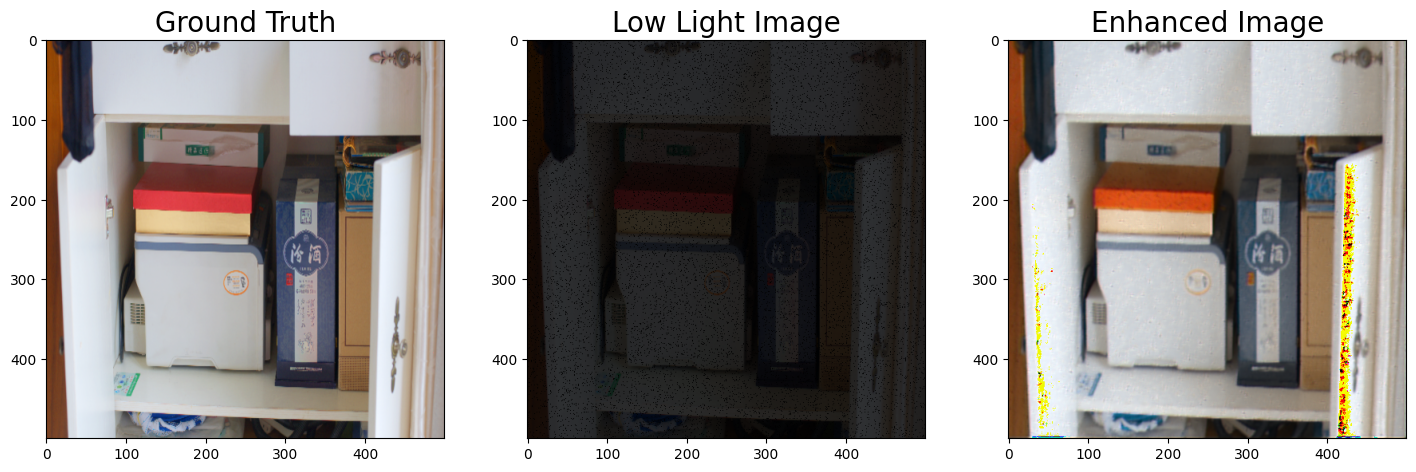

In [49]:
ImagePath=TestPath+"/55.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)
